In [1]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import chain
import patsy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
fs = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/FS_newcode_full_semifinal_ind.csv').set_index("s")

In [3]:
misscor = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/MissCor_newcode_full_semifinal_ind.csv').set_index("s")

In [4]:
phenosum = pd.read_table('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/round3_phenos_summary.tsv')

In [5]:
phenodict_biomarkers = {}
for pheno in phenosum[phenosum.trait_type=="biomarkers"].phenocode:
    phenodict_biomarkers[pheno] = phenosum.loc[phenosum.phenocode==pheno,"description"].values[0]

In [6]:
misscor_ind = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/MissCor_newcode_full_semifinal.csv').set_index("s")

In [7]:
thresh = np.sqrt(0.80)

In [8]:
fs_thresh = fs.copy()
fs_thresh[misscor<thresh]=np.nan

In [9]:
fs_thresh[misscor_ind<thresh]=np.nan

In [10]:
fs_thresh.f27[misscor_ind.f27<np.sqrt(0.90)]=np.nan

In [11]:
fs_thresh[misscor_ind.isna()] = np.nan

In [12]:
biomarkers = pd.read_table('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/round3_phenos_biomarkers.tsv').set_index("userId")
biomarkers = biomarkers.loc[fs.index]

In [13]:
grab_dilution = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/biomarkers_gwassamp/biomarkers_logt_dilution.csv').set_index("eid")
grab_dilution = grab_dilution.loc[fs.index,"30897-0.0"]

In [14]:
covs = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/to_gwas/full_covs.csv",sep=",",index_col="userId")
covs.isFemale = covs.isFemale.astype(int)

In [15]:
mycovs = covs.columns[0:21].tolist() + covs.columns[27:].tolist()

In [16]:
biomarkers = biomarkers.drop(columns=["30800","30820"])

In [17]:
input_data = fs_thresh.join(biomarkers,how="left").join(covs,how="left").join(grab_dilution,how="left")

In [18]:
coeffmat = pd.DataFrame(index=fs.columns,columns=biomarkers.columns)
pmat = pd.DataFrame(index=fs.columns,columns=biomarkers.columns)

In [19]:
for factor in fs.columns:
    temp = pd.DataFrame(index=biomarkers.columns[:-1], columns=["name","n","coef","se","teststat","p"])
    for item in biomarkers.columns:
        tempcovs = mycovs
        tempcovs = tempcovs + ["30897-0.0"]
        y=input_data[item]
        x=input_data[[factor]+tempcovs]
        x = x[x.columns[x.dropna().var()!=0]]
        x=sm.add_constant(x)
        model = sm.OLS(y, x, missing="drop").fit(cov_type='HC0')
        temp.loc[item,"name"] = phenodict_biomarkers[item]
        temp.loc[item,"n"] = model.nobs
        temp.loc[item,"coef"] = model.params[1]
        temp.loc[item,"se"] = model.bse[1]
        temp.loc[item,"teststat"] = model.tvalues[1]
        temp.loc[item,"p"] = model.pvalues[1]
        coeffmat.loc[factor,item] = model.params[1]
        pmat.loc[factor,item] = model.pvalues[1]
        #print(model.summary())
        #break 
        # temp.to_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/biomarkers_gwassamp/'+factor+"_biomarkers_phewas.csv")
        print(factor,phenodict_biomarkers[item],model.nobs,model.params[1],model.bse[1],model.tvalues[1],model.pvalues[1])

f1 Glycated haemoglobin (HbA1c) 106625.0 0.012772340045016416 0.0028129411207503067 4.540564305025197 5.61038636065135e-06
f1 Alanine aminotransferase 111730.0 0.015236351525180008 0.0027605794205800426 5.519258533767742 3.404330289728236e-08
f1 SHBG 101060.0 -0.007552411877462296 0.002840757820267504 -2.658590543544156 0.007846826284415843
f1 Total bilirubin 111320.0 -0.011642199450954922 0.0028449911586200024 -4.092174211396183 4.273473984676049e-05
f1 Total protein 102008.0 0.0012998488719010864 0.0029809984153145665 0.4360448047282579 0.6628042222747068
f1 Phosphate 101894.0 0.008327617239723532 0.0029611232797735693 2.812316966539916 0.004918600775779032
f1 Direct bilirubin 95889.0 -0.004543981581177992 0.003104624358212927 -1.4636171906457573 0.14329857286758294
f1 Albumin 102103.0 0.0010729152439487764 0.0029739369230314372 0.36077269683820884 0.7182693748979637
f1 Urate 111621.0 0.004277873213166043 0.0024885010046552893 1.719056253207589 0.08560412945501651
f1 Lipoprotein A 89

f11 Apolipoprotein B 339957.0 0.00386569793533955 0.002066700178186556 1.8704686708507183 0.061418763634331824
f11 Cystatin C 341480.0 0.03177044308083937 0.001906941806404895 16.660415632050835 2.5425143593964836e-62
f11 Glucose 312319.0 -0.009603438798984395 0.0021442729750213783 -4.478645634606596 7.511811402907078e-06
f11 LDL direct 340972.0 0.00031398560534179657 0.002038893750907623 0.15399802231088522 0.8776112949518889
f11 Creatinine 341453.0 -0.022377607212381134 0.00168371917062392 -13.290581709115349 2.625292631067871e-40
f11 Cholesterol 341629.0 0.004572231536994177 0.002002176236755939 2.2836309077378796 0.02239323173770628
f11 Triglycerides 341343.0 0.007456391230442959 0.0020338187339596476 3.666202452529331 0.0002461790564667706
f11 Vitamin D 326594.0 -0.03656077221507195 0.0020706573186419623 -17.656602029663837 9.052812268961387e-70
f12 Glycated haemoglobin (HbA1c) 306652.0 0.22331854132922885 0.0022148961617040573 100.8257385562563 0.0
f12 Alanine aminotransferase 32

f14 Aspartate aminotransferase 340277.0 -0.014160020899586588 0.002316376379022365 -6.1130052213547765 9.777217074167863e-10
f14 Urea 341320.0 -0.018537176013761848 0.0023693193380101628 -7.823840255037135 5.123581642802057e-15
f14 Calcium 312474.0 0.024880972494073676 0.0024185727699372033 10.28746077163504 8.026512733236394e-25
f14 C-reactive protein 340801.0 -0.22148864159344434 0.0022858613740529715 -96.8950453897086 0.0
f14 Alkaline phosphatase 341559.0 -0.10818840683302781 0.002289217906401667 -47.25998627325303 0.0
f14 Apolipoprotein B 339876.0 0.005086902032605032 0.002375653297704148 2.141264483972076 0.032252715500358846
f14 Cystatin C 341398.0 -0.17563785716953248 0.0021887339892792713 -80.2463241443828 0.0
f14 Glucose 312238.0 -0.05138229297822204 0.0024132362018895953 -21.291862329095277 1.3505318492997072e-100
f14 LDL direct 340891.0 0.024235967500056993 0.0023700394995254544 10.225976193607611 1.5169181639247072e-24
f14 Creatinine 341371.0 0.028880231887826492 0.00203951

f17 Urate 86227.0 0.003571474065038269 0.0029231934717903335 1.2217713605014624 0.22179410177098347
f17 Lipoprotein A 69092.0 0.0006370763086176388 0.004031182222308576 0.15803709023423856 0.8744275721689564
f17 Gamma glutamyltransferase 86282.0 -0.00016629782001157702 0.003204533875739614 -0.05189454268858215 0.9586127227221422
f17 HDL cholesterol 78782.0 -0.007342704629712432 0.0032841476891927483 -2.2358022003320097 0.025364730754379033
f17 Testosterone 78254.0 0.0038821085976297022 0.002209006588090604 1.757400190003632 0.07884962096761138
f17 Apolipoprotein A 78335.0 -0.009189858443200534 0.003334594771421036 -2.7559146082641637 0.005852827466064968
f17 IGF-1 85841.0 0.00013031290758773267 0.003358463986268786 0.03880134136335008 0.9690487753880993
f17 Aspartate aminotransferase 86020.0 -0.009867886298707365 0.003295421880234241 -2.9944227650773345 0.002749646604680284
f17 Urea 86273.0 -0.0210051086167371 0.003254363441540494 -6.454444623060929 1.086164850795477e-10
f17 Calcium 78

f19 Vitamin D 104508.0 -0.027354429219623843 0.003017672972043496 -9.064742758092862 1.2489861460152196e-19
f2 Glycated haemoglobin (HbA1c) 106437.0 0.030369756733684937 0.0034834268712385865 8.718356335951011 2.822694084005046e-18
f2 Alanine aminotransferase 111535.0 0.018972743994668605 0.003414538248132488 5.556459648693454 2.753013259290571e-08
f2 SHBG 100883.0 -0.01732584900538595 0.003446477012358765 -5.027118690551822 4.979042067956482e-07
f2 Total bilirubin 111126.0 -0.03500485802183048 0.0034588166112452783 -10.120472391633298 4.482469164789623e-24
f2 Total protein 101829.0 -0.016421251935128788 0.003729341018933849 -4.403258337534208 1.0663705727483714e-05
f2 Phosphate 101715.0 0.003068585944079167 0.003645462280258914 0.8417549567571508 0.3999251294145061
f2 Direct bilirubin 95728.0 -0.023873291651011333 0.003785566459795108 -6.3063987660920535 2.8560263325214263e-10
f2 Albumin 101924.0 -0.02441840588113534 0.003732659024744066 -6.54182600641097 6.077218419753304e-11
f2 Urat

f21 Alkaline phosphatase 312427.0 -0.07408488013706555 0.0018527421936134617 -39.986610329511336 0.0
f21 Apolipoprotein B 310896.0 -0.007539750265426951 0.0018809017794631587 -4.008582663778927 6.108425695618475e-05
f21 Cystatin C 312290.0 -0.01858909559702266 0.001695561337835022 -10.963387276073512 5.731322225672997e-28
f21 Glucose 285502.0 -0.013444601394044407 0.001958580120111939 -6.864463320130097 6.6741686161083985e-12
f21 LDL direct 311828.0 0.011475032171232758 0.0018591661686410143 6.172139082985039 6.737219295550784e-10
f21 Creatinine 312256.0 0.0756431897553842 0.0015625110945156173 48.411297699510925 0.0
f21 Cholesterol 312417.0 0.0013762693263100994 0.0018279345045097942 0.7529095396550765 0.4515042751725107
f21 Triglycerides 312163.0 -0.05245085542100643 0.0018592773651758445 -28.21034473038174 4.3661588282090584e-175
f21 Vitamin D 298633.0 0.051359555023990394 0.0018902434318097145 27.170868132481157 1.4354247727788354e-162
f22 Glycated haemoglobin (HbA1c) 106743.0 -0.0

f24 Testosterone 63953.0 0.00662432158796967 0.002766296395179684 2.394653587920896 0.01663607437120549
f24 Apolipoprotein A 65381.0 0.01704216406204716 0.0041266952168510385 4.129736548620507 3.631791622581078e-05
f24 IGF-1 70205.0 0.023574556830775563 0.004080237951715346 5.777740688104903 7.571037286240225e-09
f24 Aspartate aminotransferase 70329.0 0.009478703289612589 0.003923462359632359 2.415902695317504 0.015696255306522154
f24 Urea 70534.0 -0.004968731294018633 0.004042268171051073 -1.2291938792192156 0.21899912324684334
f24 Calcium 65849.0 0.01475187313665504 0.0042950228861488235 3.4346436626051275 0.0005933334758932482
f24 C-reactive protein 70414.0 -0.023865592234540225 0.004189344031046453 -5.696737259503335 1.2212190381495933e-08
f24 Alkaline phosphatase 70568.0 -0.007810413193240803 0.004108515471156736 -1.9010304933917683 0.05729801863169768
f24 Apolipoprotein B 70229.0 0.009938790281870613 0.004334189560441264 2.2931138897530694 0.021841448927853026
f24 Cystatin C 7054

f27 Total bilirubin 74779.0 -0.0032787887300951392 0.0032406788504822904 -1.0117598445792237 0.3116528939532678
f27 Total protein 70100.0 -0.0021931317734787134 0.003479380984620063 -0.6303224002122885 0.528483670172863
f27 Phosphate 70042.0 0.011419690630610383 0.0032923817494742943 3.468519600569953 0.0005233343494678371
f27 Direct bilirubin 63983.0 -0.006738676481378293 0.003607253603256457 -1.8680905815146838 0.06174944614041054
f27 Albumin 70201.0 0.001031187113635299 0.0034858218995783294 0.2958232357654414 0.7673650771925585
f27 Urate 75035.0 -0.00843443179331859 0.002857821758420161 -2.951349841349535 0.0031638834058194524
f27 Lipoprotein A 59781.0 0.00566376717525379 0.0038099647892596415 1.4865668027221801 0.1371292611072078
f27 Gamma glutamyltransferase 75041.0 -0.00010146059320019843 0.0031725782755519945 -0.03198048539323915 0.9744876133369206
f27 HDL cholesterol 70152.0 0.010952350699924823 0.003198268717687532 3.4244623159256555 0.0006160172720476408
f27 Testosterone 680

f29 Creatinine 340850.0 -0.03330163930339351 0.0017396236173602535 -19.143014023876162 1.1067855322308942e-81
f29 Cholesterol 341025.0 -0.005339007058270488 0.002104366315478986 -2.5371091615554815 0.011177209555033015
f29 Triglycerides 340741.0 0.02206088485762285 0.0020626890985599397 10.695206016759672 1.0718119992318057e-26
f29 Vitamin D 326017.0 0.006184243924166602 0.0021421069714407507 2.886991175798829 0.0038894513858532763
f3 Glycated haemoglobin (HbA1c) 106738.0 0.006703655022672757 0.0031420081612954045 2.1335574825206494 0.03287902151788794
f3 Alanine aminotransferase 111847.0 0.023643831793170637 0.003093856097312947 7.64218859878635 2.1356004326279166e-14
f3 SHBG 101169.0 -0.014625138484898218 0.0031465709116055528 -4.647960874155438 3.352324785358161e-06
f3 Total bilirubin 111437.0 -0.03326386202351583 0.0031914781808888987 -10.422713281483597 1.9530065440912716e-25
f3 Total protein 102117.0 -0.022191890512072755 0.003415810938262282 -6.4968146402629605 8.20384368866642e

f31 Calcium 312391.0 -0.016752547896077268 0.0024445554107489927 -6.853003954180943 7.231508635124798e-12
f31 C-reactive protein 340699.0 0.11478662527258082 0.0022973814305809145 49.96411294382054 0.0
f31 Alkaline phosphatase 341458.0 0.06914706713021943 0.0023090079799051324 29.946655763857688 4.863929296145552e-197
f31 Apolipoprotein B 339774.0 -0.01348918521283996 0.0023901955581694147 -5.643548774381857 1.6658030635720374e-08
f31 Cystatin C 341299.0 0.08125544797933269 0.0021622617951700123 37.5789130441274 4.75168667866977e-309
f31 Glucose 312155.0 0.032700340060794635 0.002439792560855761 13.402918176504704 5.813168993226178e-41
f31 LDL direct 340789.0 -0.028697060773645425 0.002375718798349784 -12.079317128600787 1.358431878296793e-33
f31 Creatinine 341271.0 0.028476016493936156 0.0019344070505785535 14.720798544142706 4.740295067223293e-49
f31 Cholesterol 341445.0 -0.04705499422468913 0.0023360725432760715 -20.142779538301472 3.1136251341419757e-90
f31 Triglycerides 341161.0 0

f34 Urate 113022.0 0.02943793784407879 0.0031616144300182195 9.311046142938165 1.2657937661751278e-20
f34 Lipoprotein A 89890.0 -0.0023094463483686756 0.004115601606947126 -0.5611442916317108 0.574699176208215
f34 Gamma glutamyltransferase 113095.0 -0.002013829532134307 0.0033418069049240733 -0.6026169642437978 0.5467635322838844
f34 HDL cholesterol 103035.0 -0.006255377362566025 0.0034729074994493633 -1.8011931972152522 0.0716724342328559
f34 Testosterone 102448.0 -0.010393944735026169 0.0023422928458008995 -4.437508637598289 9.100607115241038e-06
f34 Apolipoprotein A 102333.0 -0.0029673998475735854 0.003489358448491226 -0.850414163915051 0.3950948641604287
f34 IGF-1 112572.0 0.020465093448555398 0.0035671144684086167 5.737156356993896 9.627936579150729e-09
f34 Aspartate aminotransferase 112794.0 -0.008414589497511936 0.003450908513724121 -2.4383693349294715 0.014753691428575024
f34 Urea 113112.0 0.0075934878246535584 0.0035343329783782285 2.1484924796581906 0.03167465317684399
f34 Ca

f36 Vitamin D 275148.0 -0.01834145716192196 0.0019606339256750087 -9.354860650800658 8.370998826104854e-21
f4 Glycated haemoglobin (HbA1c) 322196.0 -0.03698452797244435 0.001999285298030269 -18.49887457727127 2.108305102686206e-76
f4 Alanine aminotransferase 337140.0 -0.003929070007312549 0.0019122308023349214 -2.054704904091585 0.03990751599151977
f4 SHBG 305621.0 0.005401210608033624 0.0019416400941691247 2.781777438699284 0.005406210030760923
f4 Total bilirubin 335858.0 0.038420705123293944 0.001955379012215049 19.648725328073894 5.928297325863797e-86
f4 Total protein 308375.0 0.008709967228919908 0.002120062289827767 4.108354396335922 3.9848830460065063e-05
f4 Phosphate 308116.0 0.010667197046641621 0.002062837638969626 5.171127792670012 2.3268536502940472e-07
f4 Direct bilirubin 287028.0 0.009569163563876748 0.0021433531763740553 4.4645761927416245 8.02273956131326e-06
f4 Albumin 308713.0 0.04205300020614888 0.0020992712596687065 20.03218974797255 2.8868090946901975e-89
f4 Urate 3

f6 C-reactive protein 293615.0 0.06743403154836965 0.0023401217505765286 28.816462874957736 1.3341331533358276e-182
f6 Alkaline phosphatase 294246.0 0.03278534903120156 0.0022689409835004197 14.449626177857569 2.5205010429997407e-47
f6 Apolipoprotein B 292813.0 -3.437739825332012e-05 0.002307372564704524 -0.01489893690303213 0.9881128080574727
f6 Cystatin C 294113.0 0.05486662344036692 0.0020928703770010967 26.2159682908724 1.7475984151896543e-151
f6 Glucose 268974.0 0.0015307419740920602 0.00239143970607287 0.6400922298834729 0.5221126402459576
f6 LDL direct 293675.0 -0.018139127012266117 0.002287422547734312 -7.9299415100340305 2.192491241194963e-15
f6 Creatinine 294077.0 -0.03160592106967273 0.0018530593157992075 -17.056076295130026 3.1501669065874908e-65
f6 Cholesterol 294234.0 -0.021536311147507342 0.002245881613359216 -9.58924594217368 8.873110836444138e-22
f6 Triglycerides 293995.0 0.062245988529309335 0.0022482274363334583 27.686695537718265 1.0097442341572639e-168
f6 Vitamin D

In [20]:
coeffmat = coeffmat.loc[sorted(coeffmat.index,key=lambda e: int(e[1:]))]

In [21]:
pmat = pmat.loc[sorted(pmat.index,key=lambda e: int(e[1:]))]

In [22]:
phenodict_biomarkers

{'30600': 'Albumin',
 '30610': 'Alkaline phosphatase',
 '30620': 'Alanine aminotransferase',
 '30630': 'Apolipoprotein A',
 '30640': 'Apolipoprotein B',
 '30650': 'Aspartate aminotransferase',
 '30660': 'Direct bilirubin',
 '30670': 'Urea',
 '30680': 'Calcium',
 '30690': 'Cholesterol',
 '30700': 'Creatinine',
 '30710': 'C-reactive protein',
 '30720': 'Cystatin C',
 '30730': 'Gamma glutamyltransferase',
 '30740': 'Glucose',
 '30750': 'Glycated haemoglobin (HbA1c)',
 '30760': 'HDL cholesterol',
 '30770': 'IGF-1',
 '30780': 'LDL direct',
 '30790': 'Lipoprotein A',
 '30800': 'Oestradiol',
 '30810': 'Phosphate',
 '30820': 'Rheumatoid factor',
 '30830': 'SHBG',
 '30840': 'Total bilirubin',
 '30850': 'Testosterone',
 '30860': 'Total protein',
 '30870': 'Triglycerides',
 '30880': 'Urate',
 '30890': 'Vitamin D'}

In [23]:
coeffmat.min().min()

-0.47966844141895654

In [24]:
bonf = 0.05/(35*28)

In [25]:
sig = pd.DataFrame(index=fs.columns,columns=biomarkers.columns)
sig = sig.loc[sorted(sig.index,key=lambda e: int(e[1:]))]

In [26]:
sig[pmat<bonf]='*'

In [27]:
sig[pmat>=bonf]=''

In [28]:
len([phenodict_biomarkers[x] for x in coeffmat.columns])

28

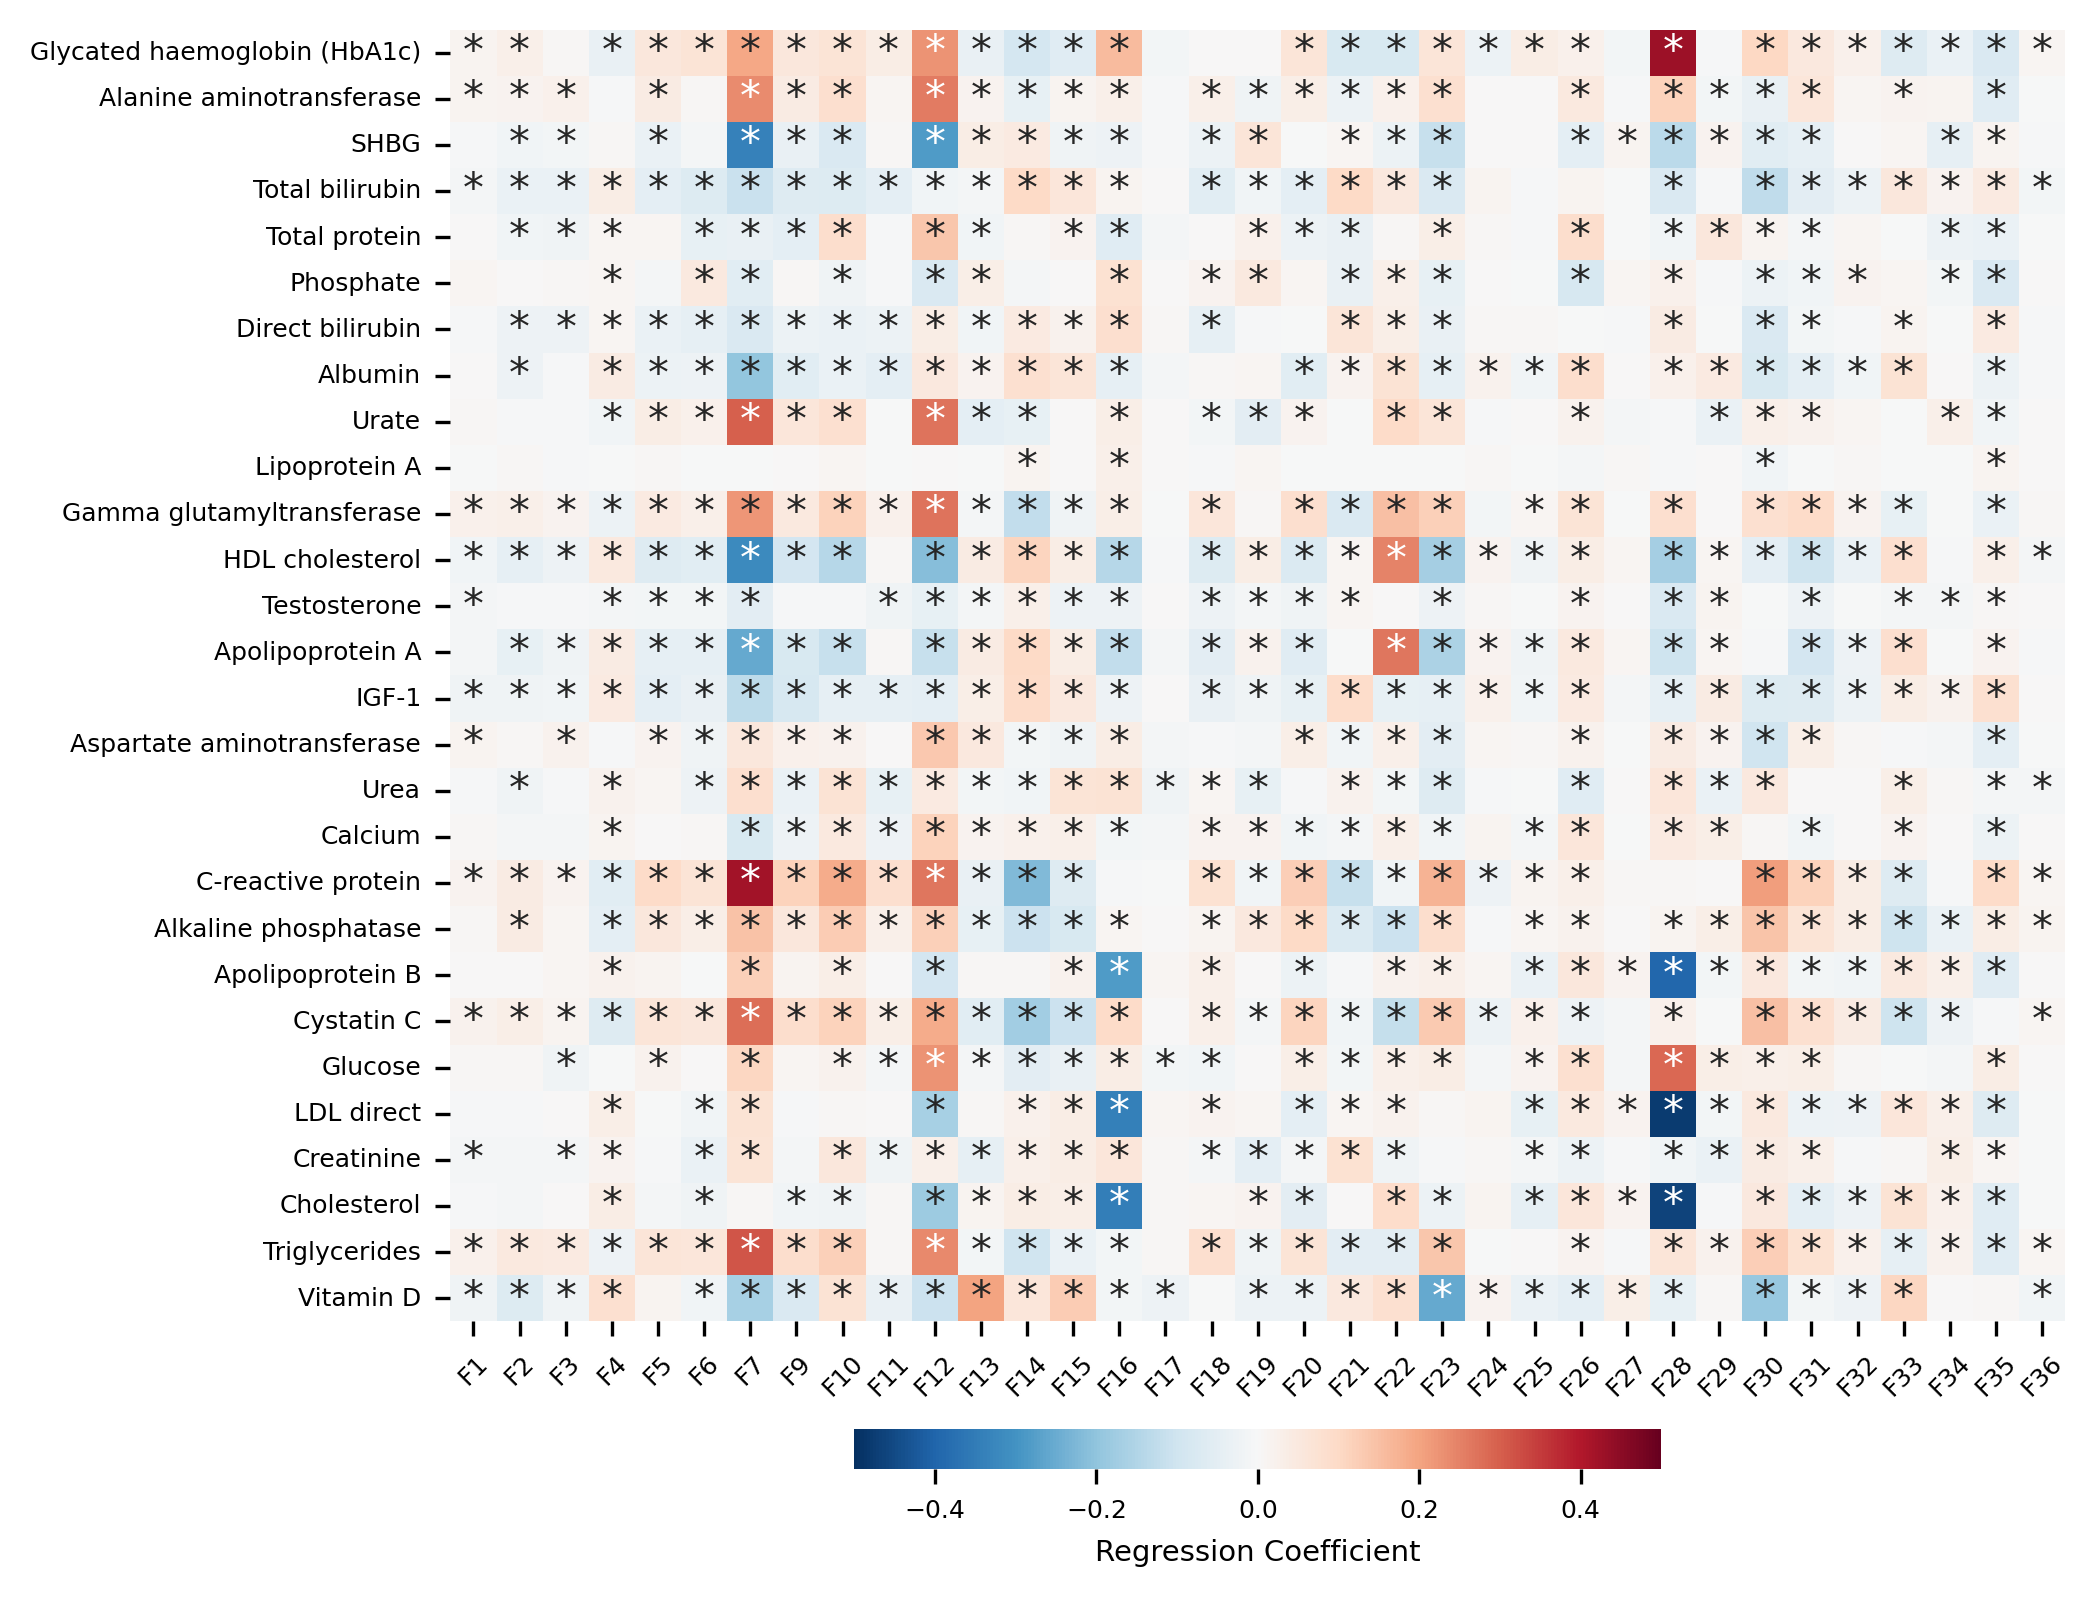

In [29]:
fig = plt.figure(figsize=(7.086,5.5),dpi=300)
ax = sns.heatmap(coeffmat.T.astype(float), square=True,vmax=0.5, vmin=-0.5,annot=sig.T,fmt='',cmap="RdBu_r",cbar=True, cbar_kws={"shrink": .5, "pad": 0.07, "fraction": 0.07, "orientation":"horizontal"})
ax.collections[0].colorbar.ax.tick_params(labelsize=6)
ax.collections[0].colorbar.set_label('Regression Coefficient',size=7)
ax.set_yticks(np.arange(0.5,28.5))
ax.set_yticklabels([phenodict_biomarkers[x] for x in coeffmat.columns], size=6)
ax.set_xticklabels([x.upper() for x in coeffmat.index.tolist()], size=5, rotation=45, horizontalalignment='center')
ax.tick_params(axis='both', which='major', labelsize=6)

fig.subplots_adjust(left=0.2, right=0.995, bottom=0.001, top=0.999)
fig.tight_layout() 
plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/edfigs_CEC/EDFig5.eps") #,bbox_inches="tight")
